# Example: DC-DC converter solved by [Uniform grid abstraction](https://github.com/dionysos-dev/Dionysos.jl/blob/master/docs/src/manual/manual.md#solvers).


We consider a boost DC-DC converter which has been widely studied from the point of view of hybrid control, see for example in  [1, V.A],[2],[3].
This is a **safety problem** for a **switching system**.

![Boost DC-DC converter.](https://github.com/dionysos-dev/Dionysos.jl/blob/master/docs/assets/dcdcboost.jpg?raw=true)

The state of the system is given by $x(t) = \begin{bmatrix} i_l(t) & v_c(t) \end{bmatrix}^\top$.
The switching system has two modes consisting in two-dimensional affine dynamics:
$$
\dot{x} = f_p(x) = A_p x + b_p,\quad p=1,2
$$
with
$$
A_1 = \begin{bmatrix} -\frac{r_l}{x_l} &0 \\ 0 & -\frac{1}{x_c}\frac{1}{r_0+r_c}  \end{bmatrix}, A_2= \begin{bmatrix} -\frac{1}{x_l}\left(r_l+\frac{r_0r_c}{r_0+r_c}\right) & -\frac{1}{x_l}\frac{r_0}{r_0+r_c}  \\ \frac{1}{x_c}\frac{r_0}{r_0+r_c}   & -\frac{1}{x_c}\frac{1}{r_0+r_c}  \end{bmatrix}, b_1 = b_2 = \begin{bmatrix} \frac{v_s}{x_l}\\0\end{bmatrix}.
$$
The goal is to design a controller to keep the state of the system in a safety region around the reference desired value, using as input only the switching
signal. In order to study the concrete system and its symbolic abstraction in a unified framework, we will solve the problem
for the sampled system with a sampling time $\tau$. For the construction of the relations in the abstraction, it is necessary to over-approximate attainable sets of
a particular cell. In this example, we consider the use of a growth bound function  [4, VIII.2, VIII.5] which is one of the possible methods to over-approximate
attainable sets of a particular cell based on the state reach by its center.

First, let us import [StaticArrays](https://github.com/JuliaArrays/StaticArrays.jl) and [Plots](https://github.com/JuliaPlots/Plots.jl).

In [1]:
using StaticArrays, Plots

At this point, we import the useful Dionysos sub-modules.

In [2]:
using Dionysos
const DI = Dionysos
const UT = DI.Utils
const DO = DI.Domain
const ST = DI.System
const SY = DI.Symbolic
const OP = DI.Optim
const AB = OP.Abstraction

Dionysos.Optim.Abstraction

### Definition of the system
we can import the module containing the DCDC problem like this

In [3]:
include(joinpath(dirname(dirname(pathof(Dionysos))), "problems", "dc_dc.jl"));

and we can instantiate the DC system with the provided system

In [4]:
concrete_problem = DCDC.problem()
concrete_system = concrete_problem.system

x0 = SVector(0.0, 0.0)
hx = SVector(2.0 / 4.0e3, 2.0 / 4.0e3)
state_grid = DO.GridFree(x0, hx)
u0 = SVector(1)
hu = SVector(1)
input_grid = DO.GridFree(u0, hu)

using JuMP
optimizer = MOI.instantiate(AB.UniformGridAbstraction.Optimizer)
MOI.set(optimizer, MOI.RawOptimizerAttribute("concrete_problem"), concrete_problem)
MOI.set(optimizer, MOI.RawOptimizerAttribute("state_grid"), state_grid)
MOI.set(optimizer, MOI.RawOptimizerAttribute("input_grid"), input_grid)
MOI.set(optimizer, MOI.RawOptimizerAttribute("jacobian_bound"), DCDC.jacobian_bound())
MOI.set(optimizer, MOI.RawOptimizerAttribute("time_step"), 0.5)
MOI.set(
    optimizer,
    MOI.RawOptimizerAttribute("approx_mode"),
    AB.UniformGridAbstraction.GROWTH,
)
MOI.set(optimizer, MOI.RawOptimizerAttribute("efficient"), true)

MOI.optimize!(optimizer)

abstract_controller = MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_controller"))
concrete_controller = MOI.get(optimizer, MOI.RawOptimizerAttribute("concrete_controller"))
abstraction_time =
    MOI.get(optimizer, MOI.RawOptimizerAttribute("abstraction_construction_time_sec"))
println("Time to construct the abstraction: $(abstraction_time)")
abstract_problem_time =
    MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_problem_time_sec"))
println("Time to solve the abstract problem: $(abstract_problem_time)")
total_time = MOI.get(optimizer, MOI.RawOptimizerAttribute("solve_time_sec"))
println("Total time: $(total_time)")

invariant_set = MOI.get(optimizer, MOI.RawOptimizerAttribute("invariant_set"))
invariant_set_complement =
    MOI.get(optimizer, MOI.RawOptimizerAttribute("invariant_set_complement"));

┌ Warning: Noise is not yet accounted for in system abstraction.
└ @ Dionysos.Optim.Abstraction.UniformGridAbstraction ~/.julia/packages/Dionysos/iYx1Z/src/optim/abstraction/UniformGridAbstraction/empty_problem.jl:395
compute_abstract_system_from_concrete_system!: started with Dionysos.System.DiscreteTimeGrowthBound
compute_abstract_system_from_concrete_system! terminated with success: 3776873 transitions created
compute_controller_safe! started

 Safety: terminated with true
Time to construct the abstraction: 3.525789976119995
Time to solve the abstract problem: 1.9629089832305908
Total time: 5.727581977844238


### Trajectory display
We choose the number of steps `nsteps` for the sampled system, i.e. the total elapsed time: `nstep`*`tstep`
as well as the true initial state `x0` which is contained in the initial state-space defined previously.

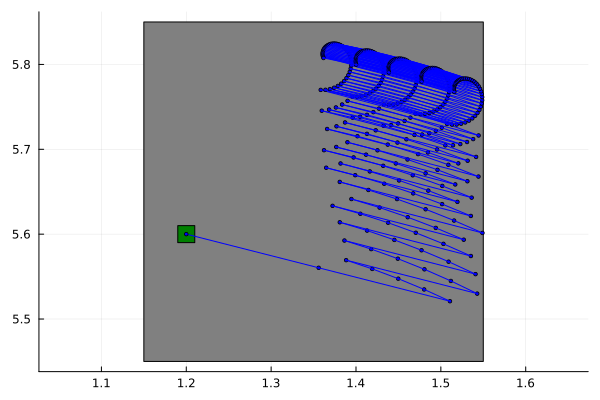

In [5]:
nstep = 300
x0 = SVector(1.2, 5.6)
control_trajectory = ST.get_closed_loop_trajectory(
    MOI.get(optimizer, MOI.RawOptimizerAttribute("discrete_time_system")),
    concrete_controller,
    x0,
    nstep,
);

fig = plot(; aspect_ratio = :equal);
plot!(concrete_system.X; label = "", color = :grey);
plot!(concrete_problem.initial_set; color = :green, label = "");
plot!(control_trajectory; arrows = false, ms = 2.0, color = :blue)

# Example: DC-DC converter solved by [Uniform grid abstraction] (https://github.com/dionysos-dev/Dionysos.jl/blob/master/docs/src/manual/manual.md#solvers) by exploiting the incremental stability of the system.
### Definition of the system
we can import the module containing the DCDC problem like this

In [6]:
include(joinpath(dirname(dirname(pathof(Dionysos))), "problems", "dc_dc.jl"));

and we can instantiate the DC system with the provided system

In [7]:
concrete_problem = DCDC.problem()
concrete_system = concrete_problem.system

origin = SVector(0.0, 0.0)
η = (2 / 4.0) * 10^(-3);

Note: In the following, `P` and `ϵ` are computed by hand, but their computation is not crucial since they only affect the visualization of the abstraction. See https://github.com/dionysos-dev/Dionysos.jl/issues/345

In [8]:
ϵ = 0.1 * 0.01
P = SMatrix{2, 2}(1.0224, 0.0084, 0.0084, 1.0031)
state_grid = DO.GridEllipsoidalRectangular(origin, SVector(η, η), P / ϵ)

u0 = SVector(1)
hu = SVector(1)
input_grid = DO.GridFree(u0, hu)

optimizer = MOI.instantiate(AB.UniformGridAbstraction.Optimizer)
MOI.set(optimizer, MOI.RawOptimizerAttribute("concrete_problem"), concrete_problem)
MOI.set(optimizer, MOI.RawOptimizerAttribute("state_grid"), state_grid)
MOI.set(optimizer, MOI.RawOptimizerAttribute("input_grid"), input_grid)
MOI.set(optimizer, MOI.RawOptimizerAttribute("jacobian_bound"), DCDC.jacobian_bound())
MOI.set(
    optimizer,
    MOI.RawOptimizerAttribute("approx_mode"),
    AB.UniformGridAbstraction.CENTER_SIMULATION,
)
MOI.set(optimizer, MOI.RawOptimizerAttribute("time_step"), 0.5)
MOI.optimize!(optimizer);

abstract_controller = MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_controller"))
concrete_controller = MOI.get(optimizer, MOI.RawOptimizerAttribute("concrete_controller"))
abstraction_time =
    MOI.get(optimizer, MOI.RawOptimizerAttribute("abstraction_construction_time_sec"))
println("Time to construct the abstraction: $(abstraction_time)")
abstract_problem_time =
    MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_problem_time_sec"))
println("Time to solve the abstract problem: $(abstract_problem_time)")
total_time = MOI.get(optimizer, MOI.RawOptimizerAttribute("solve_time_sec"))
println("Total time: $(total_time)")

┌ Warning: Noise is not yet accounted for in system abstraction.
└ @ Dionysos.Optim.Abstraction.UniformGridAbstraction ~/.julia/packages/Dionysos/iYx1Z/src/optim/abstraction/UniformGridAbstraction/empty_problem.jl:395
compute_abstract_system_from_concrete_system!: started with Dionysos.System.DiscreteTimeCenteredSimulation{MathematicalSystems.ConstrainedBlackBoxControlDiscreteSystem{Dionysos.System.var"#35#36"{Int64, Main.var"##278".DCDC.var"#14#15"{StaticArraysCore.SVector{2, Float64}, StaticArraysCore.SMatrix{2, 2, Float64, 4}, StaticArraysCore.SMatrix{2, 2, Float64, 4}}, Float64}, Dionysos.Utils.HyperRectangle{StaticArraysCore.SVector{2, Float64}}, Dionysos.Utils.HyperRectangle{StaticArraysCore.SVector{1, Int64}}}}
compute_abstract_system_from_concrete_system! terminated with success: 932213 transitions created
compute_controller_safe! started

 Safety: terminated with true
Time to construct the abstraction: 1.0067148208618164
Time to solve the abstract problem: 0.6471879482269287
T

### Trajectory display
We choose the number of steps `nsteps` for the sampled system, i.e. the total elapsed time: `nstep`*`tstep`
as well as the true initial state `x0` which is contained in the initial state-space defined previously.

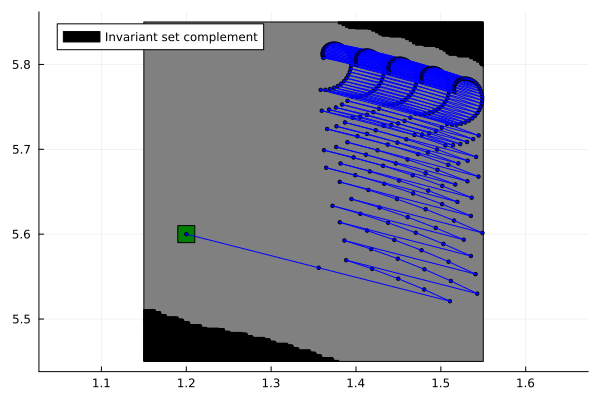

In [9]:
nstep = 300
x0 = SVector(1.2, 5.6)
control_trajectory = ST.get_closed_loop_trajectory(
    MOI.get(optimizer, MOI.RawOptimizerAttribute("discrete_time_system")),
    concrete_controller,
    x0,
    nstep,
)

fig = plot(; aspect_ratio = :equal);
plot!(concrete_system.X; label = "", color = :grey);
plot!(invariant_set_complement; color = :black, label = "Invariant set complement")
plot!(concrete_problem.initial_set; color = :green, label = "");
plot!(control_trajectory; arrows = false, ms = 2.0, color = :blue)

### References
1. A. Girard, G. Pola and P. Tabuada, "Approximately Bisimilar Symbolic Models for Incrementally Stable Switched Systems," in IEEE Transactions on Automatic Control, vol. 55, no. 1, pp. 116-126, Jan. 2010.
2. S. Mouelhi, A. Girard, and G. Gössler. “CoSyMA: a tool for controller synthesis using multi-scale abstractions”. In: HSCC. ACM. 2013, pp. 83–88.
3. A. Girard. “Controller synthesis for safety and reachability via approximate bisimulation”. In: Automatica 48.5 (2012), pp. 947–953.
4. G. Reissig, A. Weber and M. Rungger, "Feedback Refinement Relations for the Synthesis of Symbolic Controllers," in IEEE Transactions on Automatic Control, vol. 62, no. 4, pp. 1781-1796.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*